In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm

/anaconda/envs/onnx/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
num_samples = 100

In [3]:
samples_df = pd.DataFrame({
    'coffee_p': np.cumsum(np.random.uniform(-1,1,(num_samples))),
    'oil_p': np.cumsum(np.random.uniform(-1,1,(num_samples))),
    'event_dummy': np.concatenate(
        ([0]*int(num_samples*1/4),
         [1]*int(num_samples*1/2), 
         [0]*int(num_samples*1/4)), axis=0)})

In [4]:
print(samples_df.shape)
samples_df.head()

(100, 3)


,coffee_p,event_dummy,oil_p
0,-0.253422,0,-0.345750
1,-0.221200,0,0.139037
2,-1.062863,0,-0.204733
3,-0.920825,0,0.099058
4,-1.033618,0,0.743903


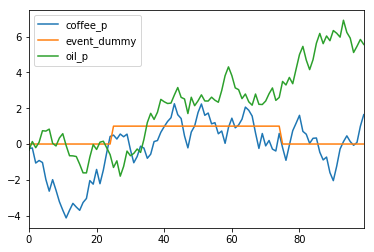

In [5]:
samples_df.plot()

In [6]:
# Regress coffee prices on event_dummy and oil prices
y = samples_df['coffee_p'].values
X = samples_df[['event_dummy', 'oil_p']].values

In [7]:
# Run OLS regresion
mod = sm.OLS(y, X)
res = mod.fit()

In [8]:
# Regression results
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.106
Model:                            OLS   Adj. R-squared:                  0.088
Method:                 Least Squares   F-statistic:                     5.813
Date:                Tue, 28 Nov 2017   Prob (F-statistic):            0.00412
Time:                        22:03:42   Log-Likelihood:                -178.34
No. Observations:                 100   AIC:                             360.7
Df Residuals:                      98   BIC:                             365.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.5829      0.227      2.569      0.012       0.133       1.033
x2             0.0480      0.051      0.948      0.345      -0.052       0.148
==============================================================================
Omnibus:                        9.749   Durbin-Watson:                   0.159
Prob(Omnibus):                  0.008   Jarque-Bera (JB):               10.254
Skew:                          -0.783   Prob(JB):                      0.00593
Kurtosis:                       3.091   Cond. No.                         4.99
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The p-stat suggests that our results are strongly significant at the 0.001 level and we have a high R-squared value suggesting we can explain a lot of the y-variable with our data.

... But this data is just noise ...

The Durbin-Watson statistic is nearly 0, which suggests very strong serial auto-correlatoin, violating the assumptions for our OLS regression

**Let's try again but with first-difference**

In [9]:
samples_df_fd = pd.DataFrame({
    'coffee_p': samples_df[['coffee_p']].diff()[1:].values.squeeze(),
    'oil_p': samples_df[['oil_p']].diff()[1:].values.squeeze(),
    'event_dummy': samples_df[['event_dummy']][1:].values.squeeze()})

In [10]:
print(samples_df_fd.shape)
samples_df_fd.head()

(99, 3)


,coffee_p,event_dummy,oil_p
0,0.032222,0,0.484787
1,-0.841663,0,-0.343770
2,0.142038,0,0.303791
3,-0.112793,0,0.644845
4,-0.946795,0,-0.020846


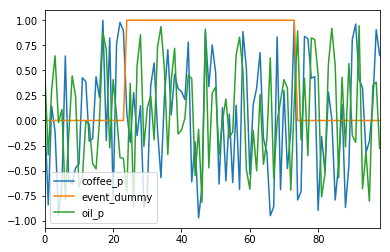

In [11]:
samples_df_fd.plot()

In [12]:
y = samples_df_fd['coffee_p'].values
X = samples_df_fd[['event_dummy', 'oil_p']].values
mod = sm.OLS(y, X)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.020
Method:                 Least Squares   F-statistic:                   0.04641
Date:                Tue, 28 Nov 2017   Prob (F-statistic):              0.955
Time:                        22:03:43   Log-Likelihood:                -86.536
No. Observations:                  99   AIC:                             177.1
Df Residuals:                      97   BIC:                             182.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0011      0.083      0.013      0.989      -0.164       0.166
x2             0.0353      0.117      0.302      0.763      -0.197       0.268
==============================================================================
Omnibus:                       31.400   Durbin-Watson:                   1.795
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                5.840
Skew:                          -0.028   Prob(JB):                       0.0539
Kurtosis:                       1.811   Cond. No.                         1.42
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

This time we get the expected results, the explanatory variables are just random noise and explain nothing

**Instead of looking at the Durbin-Watson statistic to realise we had serial autocorrelation, could we have just done this?**

**Consider a standard machine-learning pipeline**

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn import linear_model

In [14]:
# Our original data
y = samples_df['coffee_p'].values
X = samples_df[['event_dummy', 'oil_p']].values

In [20]:
# Split into train-test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

In [21]:
# Run sklearn linear regression
reg = linear_model.LinearRegression()
reg.fit(X=X_train, y=y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [23]:
# Predict on test-data
prediction = reg.predict(X=X_test)

In [24]:
# What's the mean-squared-error
np.sum((y_test-prediction)**2)/len(prediction)

1.0290116644702429

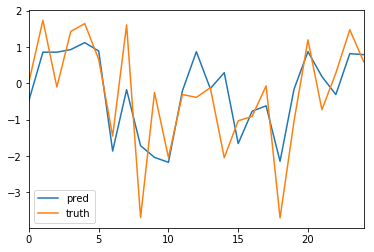

In [25]:
# Let's compare our prediction with the truth
test_df = pd.DataFrame({
    'truth': y_test,
    'pred': prediction})
test_df.plot()

**Did we learn to predict random-noise?**